In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime
import calendar
import os

In [2]:
DATA_CLEANED_PATH = '../data/interim/data_no_cancellations.parquet'
DATA_CANCELED_PATH = '../data/interim/data_cancellations.parquet'

In [3]:
data_cancellations = pd.read_parquet(DATA_CANCELED_PATH)
data_no_cancellations = pd.read_parquet(DATA_CLEANED_PATH)
data_cancellations.head()


hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
0         0    2015-07-01                    2015-05-06          PRT   
1         0    2015-07-01                    2015-04-22          PRT   
2         0    2015-07-01                    2015-06-23          PRT   
3         0    2015-07-01                    2015-05-11          PRT   
4         0    2015-07-01                    2015-05-29          PRT   

   kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
0                 2            1       61.437192  1075633               2   
1                 2            2      150.365262  1056139               2   
2                 2            3      142.635814  1020092               2   
3                 2            3      113.277032  1018277               2   
4                 0            3      105.416363  1035627               2   

   duljina_boravka  raspon_dolazak_rezervacija  
0                3                           1  
1                3                           3  
2                4                          75  
3                7                         178  
4               10                         181

Opis kolona:
- hotel_id : int, dvije vrste hotela: hotel 0 i hotel 1
- datum_dolaska :  datum kada bi gost trebao stići u hotel
- datum_otkazivanja_rezervacije: samo za podatkovni okvir s podacima o otkazanim rezervacijama
- zemlja_gosta : zemlja iz koje gost dolazi. Kategorije su zapisane u ISO 3155–3:2013 formatu
- kanal_prodaje_id : id kanala prodaje preko kojeg je rezervacija napravljena (primjeri: direktna rezervacija, agencija, online)
- tip_sobe_id : id tipa sobe koju je gost rezervirao
- cijena_nocenja : cijena jednog noćenja za pojedinu rezeraciju
- gost_id : identifikacijski broj gosta
- ukupno_gostiju : int, broj ukupnog broja gostiju za danu rezervaciju
- duljina_boravka: dani boravka osoba u hotelu u danoj rezervaciji
- raspon_dolazak_rezervacija : razlika u brojima dana izmedu dana dolaska gosta i dana kreiranja rezervacije

In [4]:
hotel_zero_cancellations = data_cancellations[data_cancellations['hotel_id'] == 0]
hotel_one_cancellations = data_cancellations[data_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_cancellations)+ len(hotel_one_cancellations)) == len(data_cancellations)

In [5]:
hotel_zero_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 0]
hotel_one_no_cancellations = data_no_cancellations[data_no_cancellations['hotel_id'] == 1]

assert (len(hotel_zero_no_cancellations)+ len(hotel_one_no_cancellations)) == len(data_no_cancellations)

In [6]:
percent_hotel_zero_cancellations = (len(hotel_zero_cancellations) / len(data_cancellations)) * 100
percent_hotel_one_cancellations = (len(hotel_one_cancellations) / len(data_cancellations)) * 100
percent_hotel_zero_no_cancellations = (len(hotel_zero_no_cancellations) / len(data_no_cancellations)) * 100
percent_hotel_one_no_cancellations = (len(hotel_one_no_cancellations) / len(data_no_cancellations)) * 100

print(f"Prvi hotel ima {percent_hotel_zero_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_cancellations} % svih zapisa o otkazima u originalnom podatkovnom skupu")

print(f"Prvi hotel ima {percent_hotel_zero_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")
print(f"Drugi hotel ima {percent_hotel_one_no_cancellations} % svih zapisa bez otkaza u originalnom podatkovnom skupu")

Prvi hotel ima 25.105485232067508 % svih zapisa o otkazima u originalnom podatkovnom skupu
Drugi hotel ima 74.89451476793249 % svih zapisa o otkazima u originalnom podatkovnom skupu
Prvi hotel ima 38.05994373512227 % svih zapisa bez otkaza u originalnom podatkovnom skupu
Drugi hotel ima 61.94005626487773 % svih zapisa bez otkaza u originalnom podatkovnom skupu


### Zanimaju nas zemlje podrijetla gostiju

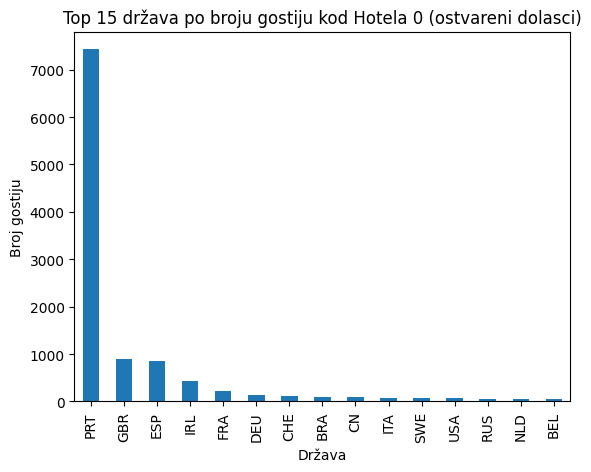

In [7]:
n = 15
top_countries_cancel_0 = hotel_zero_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

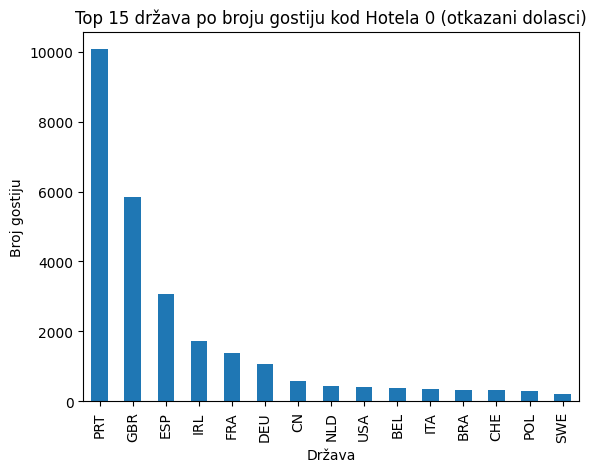

In [8]:
n = 15
top_countries_no_cancel_0 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_0.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (otkazani dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

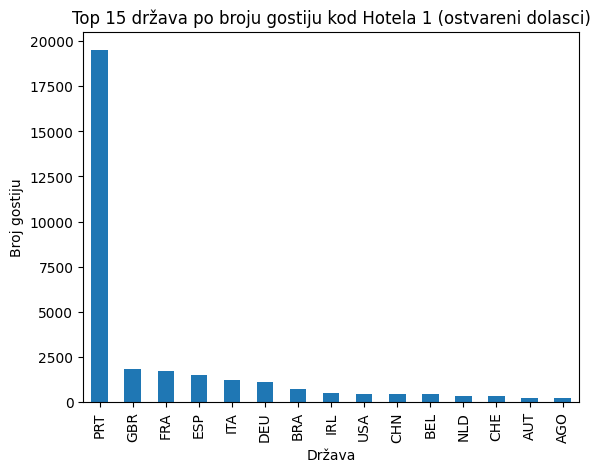

In [9]:
n = 15
top_countries_cancel_1 = hotel_one_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 1 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

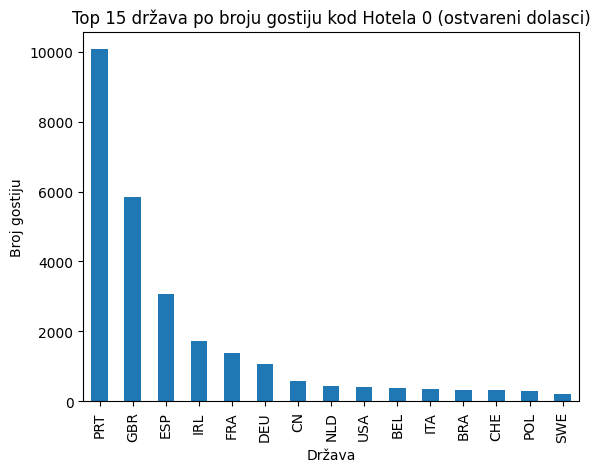

In [10]:
n = 15
top_countries_no_cancel_1 = hotel_zero_no_cancellations['zemlja_gosta'].value_counts()[0:n]
top_countries_no_cancel_1.plot(kind='bar')
plt.title(f'Top {n} država po broju gostiju kod Hotela 0 (ostvareni dolasci)')
plt.xlabel('Država')
plt.ylabel('Broj gostiju')
plt.show()

In [11]:
min_date = data_no_cancellations['datum_dolaska'].min()
max_date = data_no_cancellations['datum_dolaska'].max()

print(f"Svi zapisi su u razdoblju od {min_date} do {max_date}")

Svi zapisi su u razdoblju od 2015-01-01 00:00:00 do 2017-12-31 00:00:00


# Promatranje cijene u hotelima

- Gledamo cijene na sljedeći način:
    - za svaku rezervaciju dobijemo cijenu po osobi
    - za svaki dan/tjedan/mjesec dobijemo prosječnu cijenu (uzimajući i ne uzimajući godinu u obzir)
    - napravimo isto za različite vrste soba i kanala prodaje
    - napravimo sve prethodno za ostvarene i neostvarene rezervacije obaju hotela

In [12]:
# DODANO ZBOG PODIGNUTOG UPOZORENJA OD PYTHONA
hotel_zero_cancellations = hotel_zero_cancellations.copy()
hotel_one_cancellations = hotel_one_cancellations.copy()
hotel_zero_no_cancellations = hotel_zero_no_cancellations.copy()
hotel_one_no_cancellations = hotel_one_no_cancellations.copy()

In [13]:
hotel_zero_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_cancellations['datum_dolaska'])
hotel_one_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_cancellations['datum_dolaska'])
hotel_zero_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_zero_no_cancellations['datum_dolaska'])
hotel_one_no_cancellations['datum_dolaska'] = pd.to_datetime(hotel_one_no_cancellations['datum_dolaska'])

KORAK 1: Cijena po osobi po rezervaciji

In [14]:
hotel_zero_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_cancellations['cijena_nocenja'] / hotel_zero_cancellations['ukupno_gostiju']
hotel_one_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_cancellations['cijena_nocenja'] / hotel_one_cancellations['ukupno_gostiju']
hotel_zero_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_zero_no_cancellations['cijena_nocenja'] / hotel_zero_no_cancellations['ukupno_gostiju']
hotel_one_no_cancellations.loc[:, 'cijena_nocenja_po_osobi'] = hotel_one_no_cancellations['cijena_nocenja'] / hotel_one_no_cancellations['ukupno_gostiju']

### HOTEL 0 otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [15]:
average_daily_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.year, hotel_zero_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [16]:
overall_average_monthly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price = hotel_zero_cancellations.groupby(hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [17]:
average_by_daily_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [18]:
average_by_daily_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel = hotel_zero_cancellations.groupby([hotel_zero_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 0 ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [19]:
average_daily_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.year, hotel_zero_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()

In [20]:
overall_average_monthly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_zero_no = hotel_zero_no_cancellations.groupby(hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [21]:
average_by_daily_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [22]:
average_by_daily_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_zero_no = hotel_zero_no_cancellations.groupby([hotel_zero_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 1 ostvareni dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [23]:
average_daily_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.year, hotel_one_no_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [24]:
overall_average_monthly_price_hotel_one_no = hotel_one_no_cancellations.groupby(hotel_one_no_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_one_no = hotel_one_no_cancellations.groupby(hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()


KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [25]:
average_by_daily_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()


KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [26]:
average_by_daily_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_one_no = hotel_one_no_cancellations.groupby([hotel_one_no_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

### HOTEL 1 otkazani dolasci

KORAK 2: Izračun prosječne dnevne, tjedne i mjesečne cijene po osobi

In [27]:
average_daily_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.date])['cijena_nocenja_po_osobi'].mean()
average_weekly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week])['cijena_nocenja_po_osobi'].mean()
average_monthly_price_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.year, hotel_one_cancellations['datum_dolaska'].dt.month])['cijena_nocenja_po_osobi'].mean()


In [28]:

overall_average_monthly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.month)['cijena_nocenja_po_osobi'].mean()
overall_average_weekly_price_hotel_one = hotel_one_cancellations.groupby(hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week)['cijena_nocenja_po_osobi'].mean()

KORAK 3: Izračun prosječne dnevne, tjedne i mjesečne cijene po vrsti sobe

In [29]:
average_by_daily_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_room_type_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'tip_sobe_id'])['cijena_nocenja_po_osobi'].mean()

KORAK 4: Izračun prosječne dnevne, tjedne i mjesečne cijene po kanalu prodaje

In [30]:
average_by_daily_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.date, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_monthly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.month, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()
average_by_weekly_sales_channel_hotel_one = hotel_one_cancellations.groupby([hotel_one_cancellations['datum_dolaska'].dt.isocalendar().week, 'kanal_prodaje_id'])['cijena_nocenja_po_osobi'].mean()

##  Vizualizacije promjena cijena

### HOTEL 0 otkazani dolasci

<Figure size 1200x600 with 0 Axes>

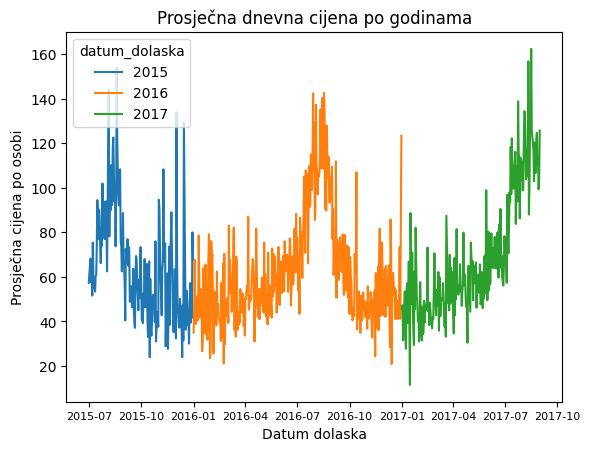

<Figure size 1200x600 with 0 Axes>

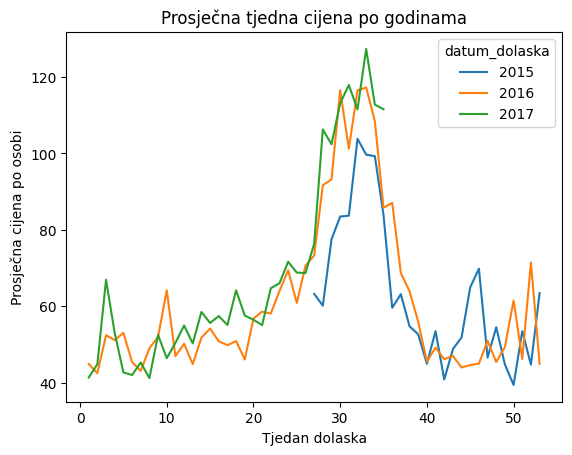

<Figure size 1200x600 with 0 Axes>

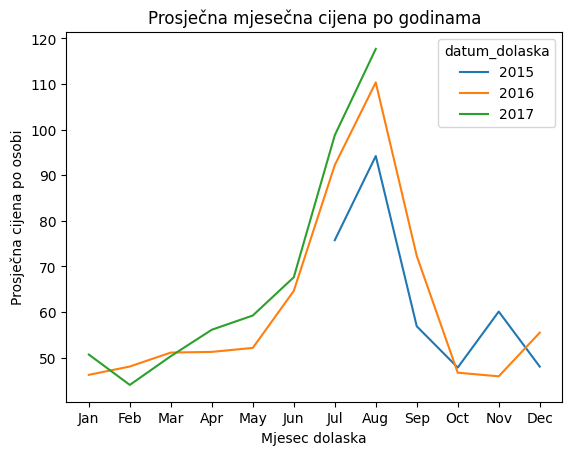

In [31]:
plt.figure(figsize=(12,6))
average_daily_price.unstack(level=0).plot()  
plt.title('Prosječna dnevna cijena po godinama')
plt.xlabel('Datum dolaska')
plt.xticks(fontsize=8)
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_weekly_price.unstack(level=0).plot()
plt.title('Prosječna tjedna cijena po godinama')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12,6))
average_monthly_price.unstack(level=0).plot()  
plt.title('Prosječna mjesečna cijena po godinama')
plt.xlabel('Mjesec dolaska')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.ylabel('Prosječna cijena po osobi')
plt.show()

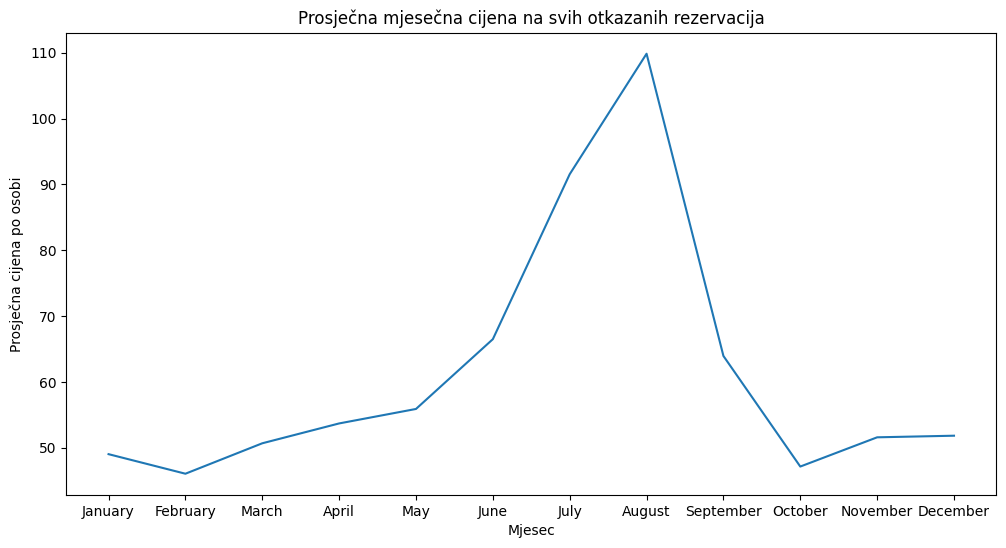

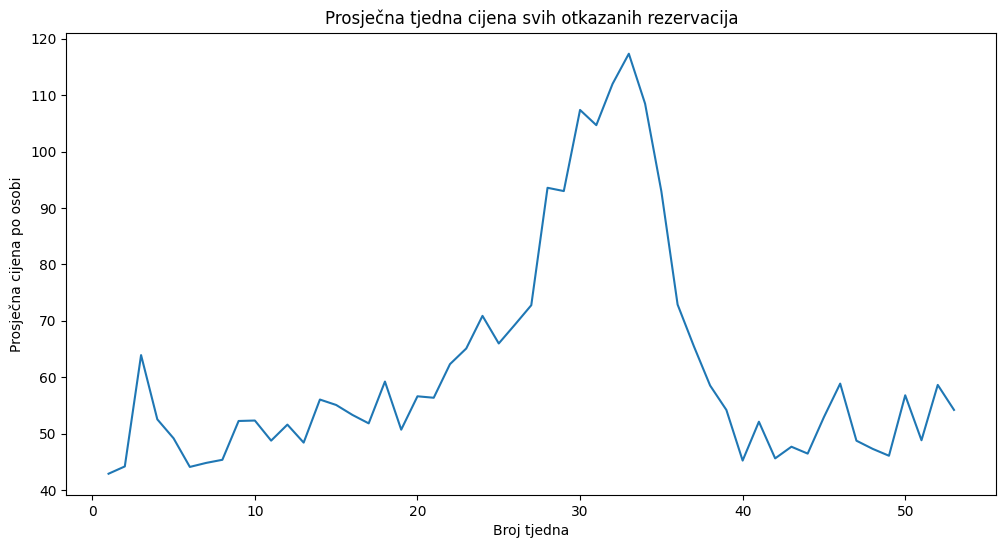

In [32]:
month_names = [calendar.month_name[i] for i in range(1, 13)]

plt.figure(figsize=(12, 6))
overall_average_monthly_price.plot()
plt.title('Prosječna mjesečna cijena na svih otkazanih rezervacija')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])  
plt.xlabel('Mjesec')
plt.ylabel('Prosječna cijena po osobi')
plt.show()

plt.figure(figsize=(12, 6))
overall_average_weekly_price.plot()
plt.title('Prosječna tjedna cijena svih otkazanih rezervacija')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosječna cijena po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

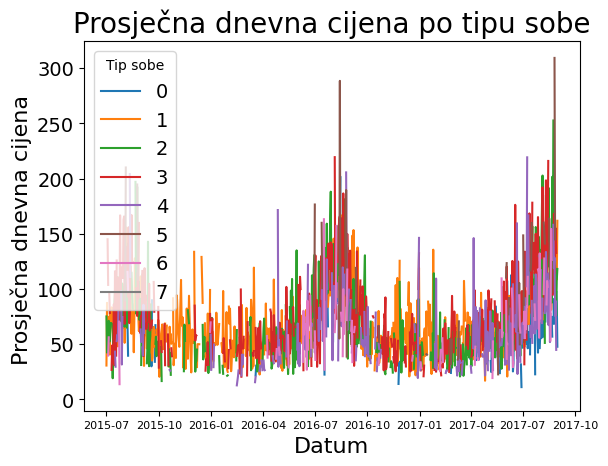

In [33]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type.unstack(level=1).plot() 
plt.title('Prosječna dnevna cijena po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna dnevna cijena ', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

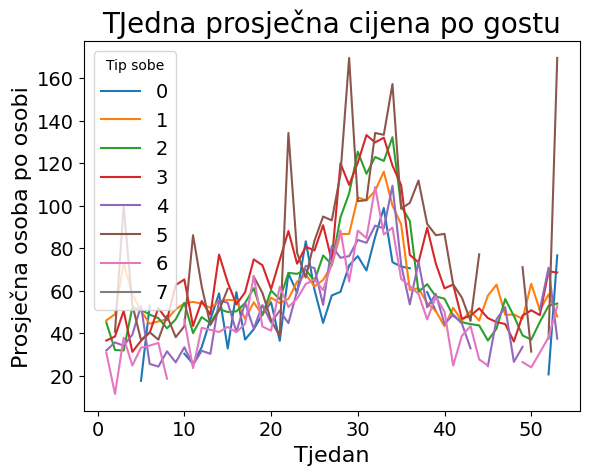

In [34]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type.unstack(level=1).plot()  
plt.title('TJedna prosječna cijena po gostu', fontsize=20)
plt.xlabel('Tjedan', fontsize=16)
plt.ylabel('Prosječna osoba po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()



<Figure size 2800x2000 with 0 Axes>

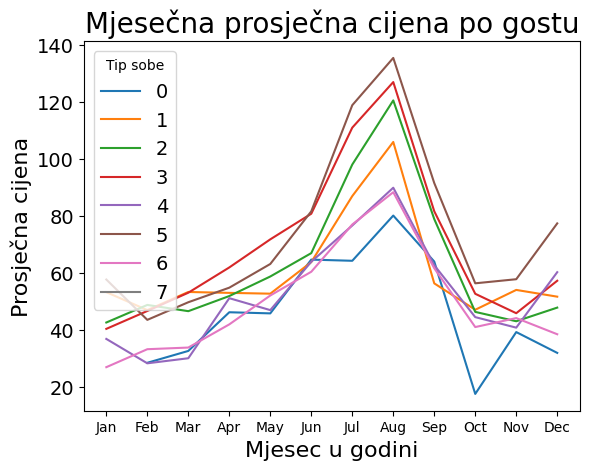

In [35]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type.unstack(level=1).plot() 
plt.title('Mjesečna prosječna cijena po gostu', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosječna cijena', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

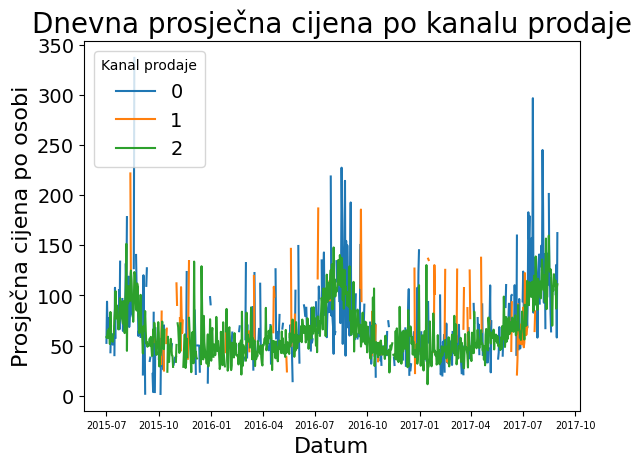

In [36]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel.unstack(level=1).plot()  
plt.title('Dnevna prosječna cijena po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

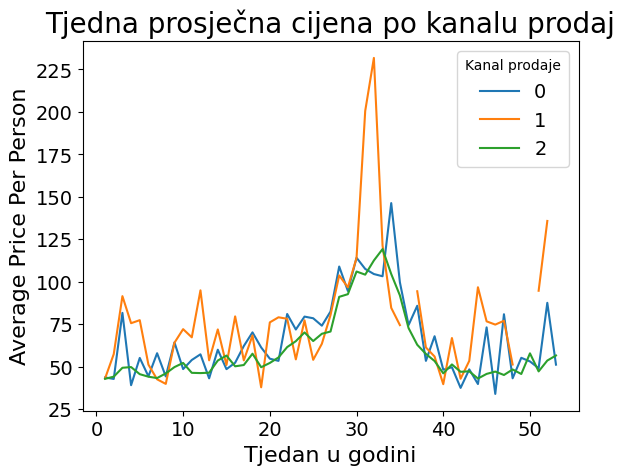

In [37]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel.unstack(level=1).plot()
plt.title('Tjedna prosječna cijena po kanalu prodaj', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Average Price Per Person', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

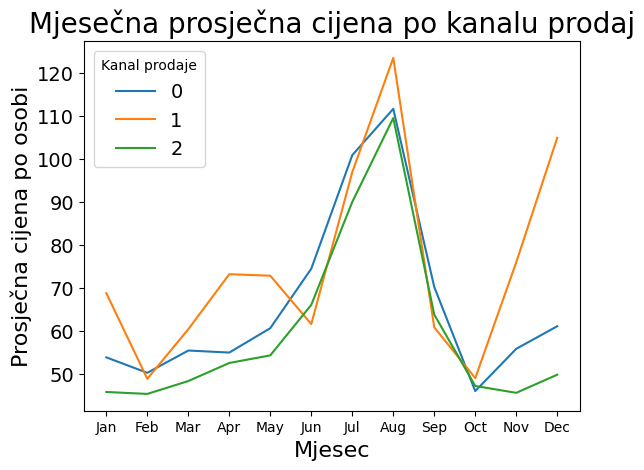

In [38]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel.unstack(level=1).plot()  
plt.title('Mjesečna prosječna cijena po kanalu prodaj', fontsize=20)
plt.xlabel('Mjesec', fontsize=16)
plt.ylabel('Prosječna cijena po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()



### HOTEL 0 ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

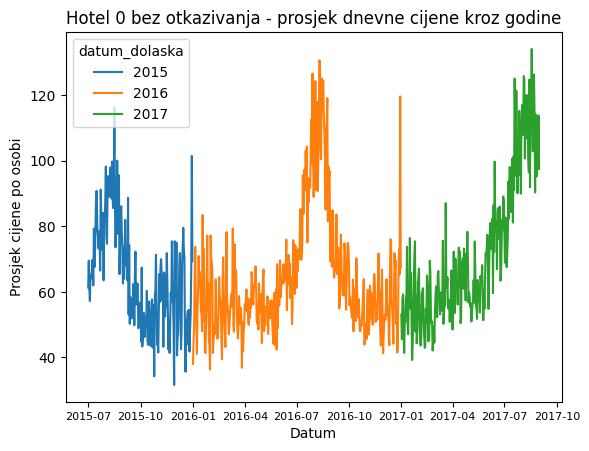

In [39]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

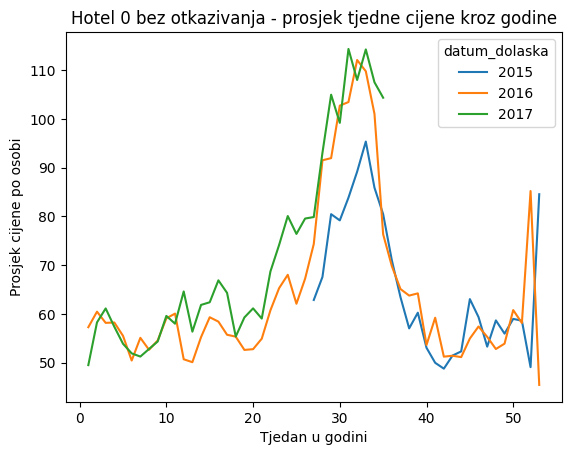

In [40]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

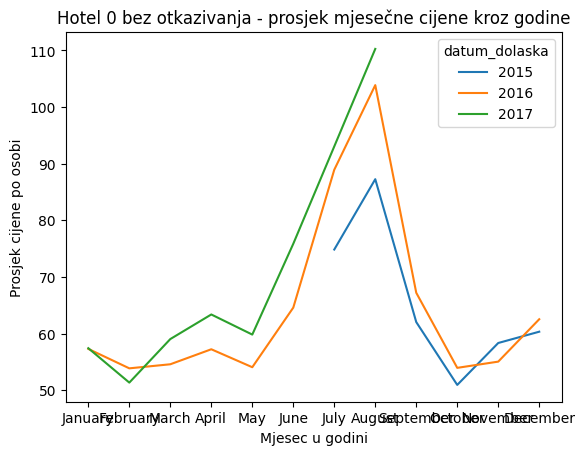

In [41]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_zero_no.unstack(level=0).plot()
plt.title('Hotel 0 bez otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.show()


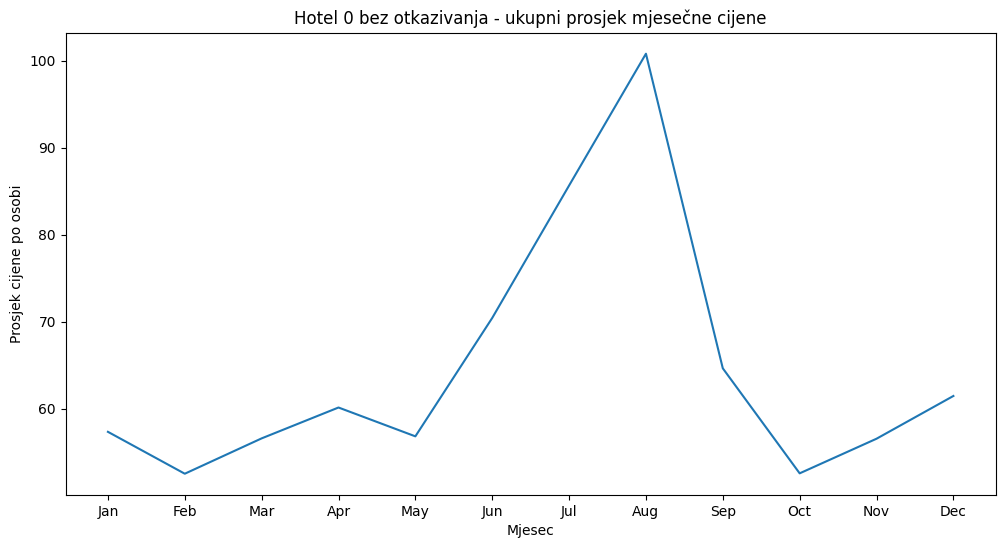

In [42]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_zero_no.plot()
plt.title('Hotel 0 bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

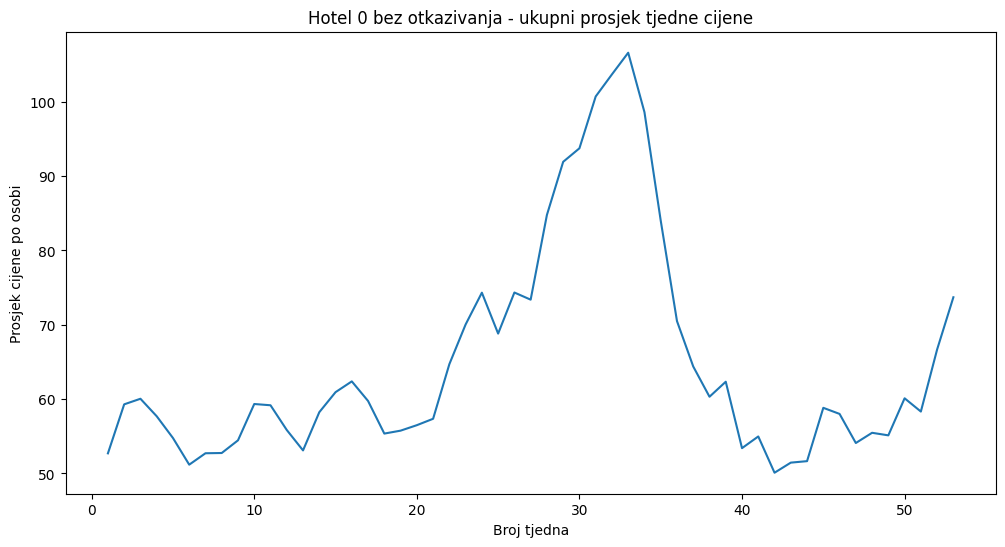

In [43]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_zero_no.plot()
plt.title('Hotel 0 bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

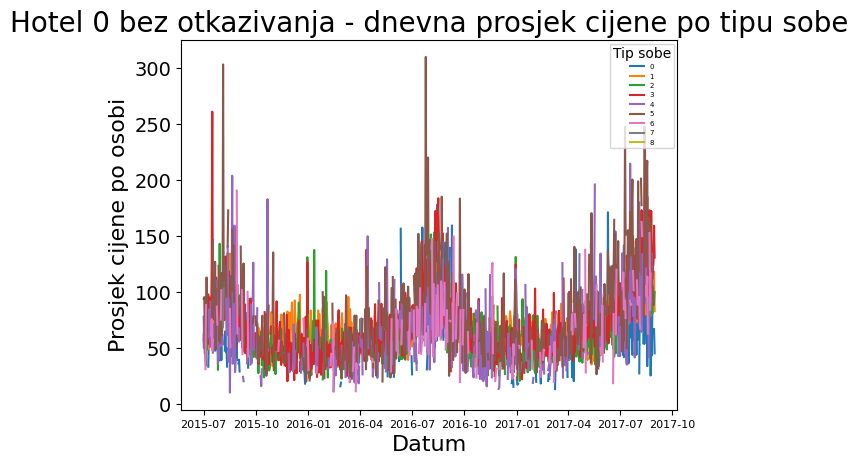

In [44]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - dnevna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=5)
plt.show()


<Figure size 2800x2000 with 0 Axes>

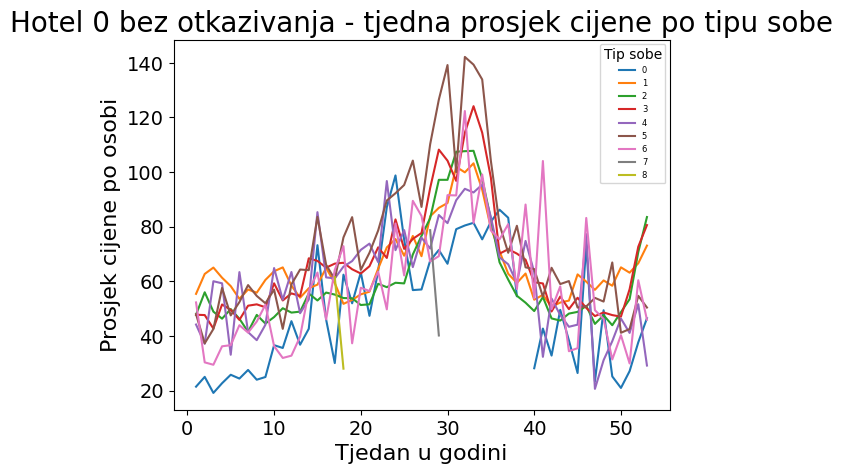

In [45]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - tjedna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=6)
plt.show()

<Figure size 2800x2000 with 0 Axes>

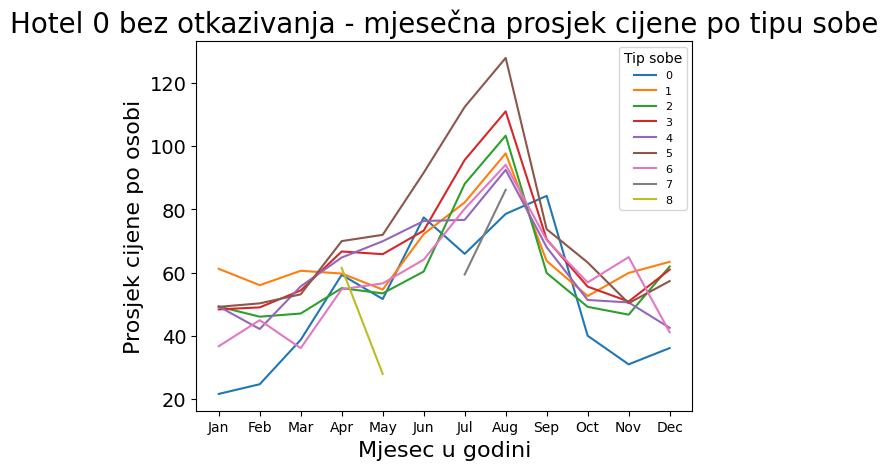

In [46]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - mjesečna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

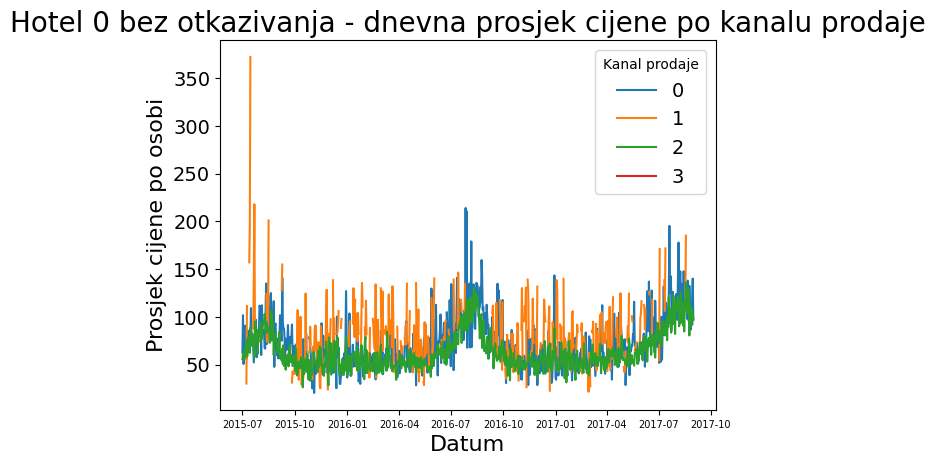

In [47]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - dnevna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()


<Figure size 2800x2000 with 0 Axes>

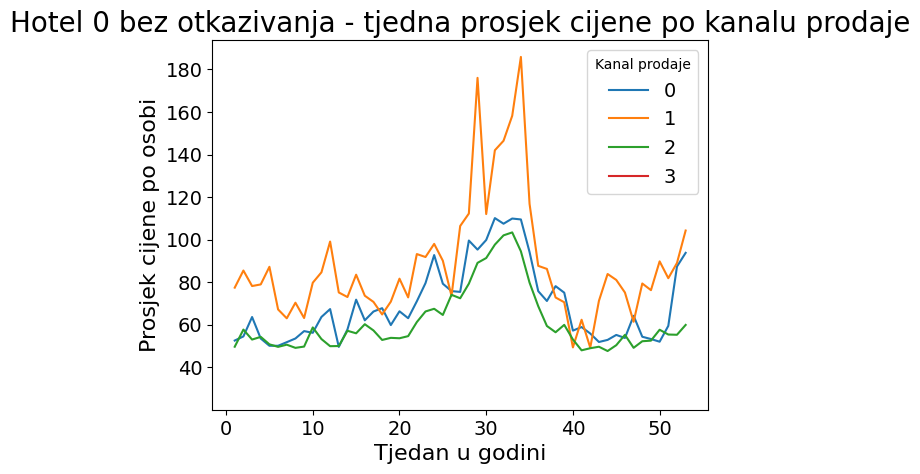

In [48]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - tjedna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

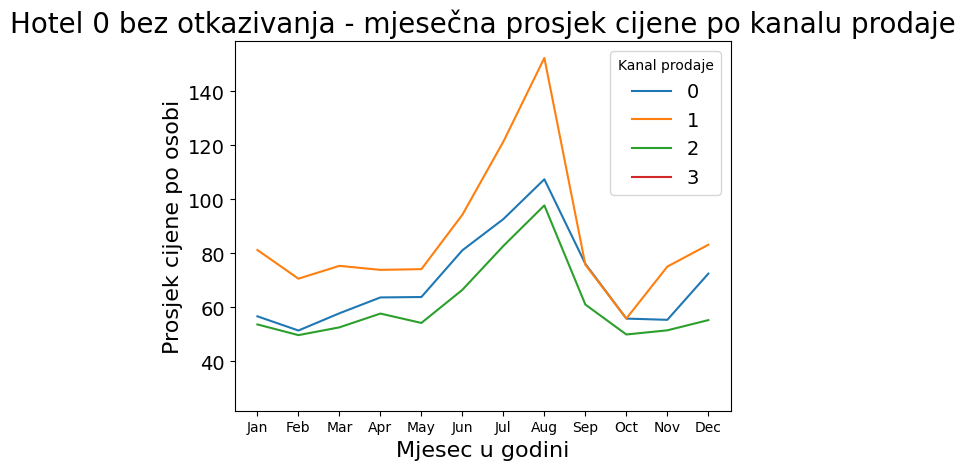

In [49]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_zero_no.unstack(level=1).plot()
plt.title('Hotel 0 bez otkazivanja - mjesečna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

### HOTEL 1 otkazani dolasci

<Figure size 2800x2000 with 0 Axes>

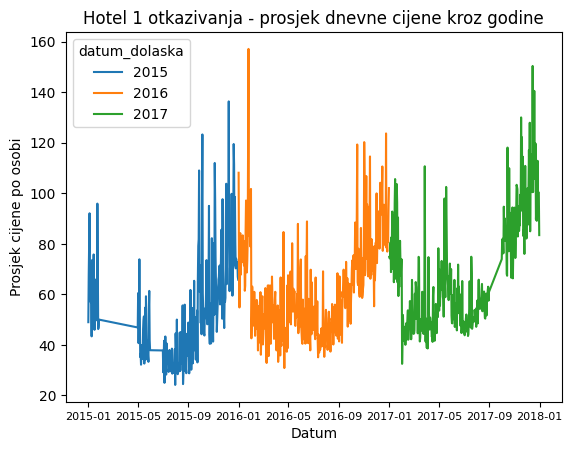

In [50]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek dnevne cijene kroz godine')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

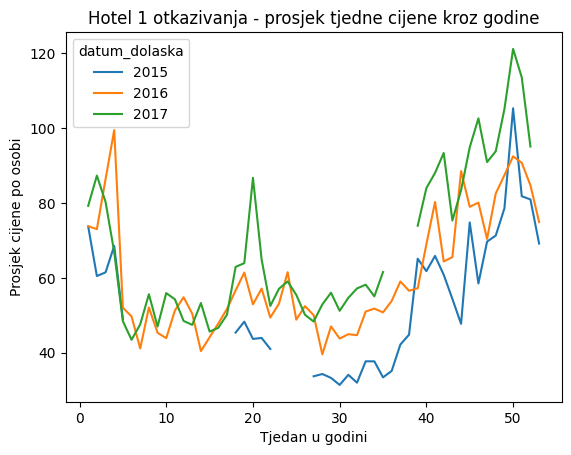

In [51]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek tjedne cijene kroz godine')
plt.xlabel('Tjedan u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

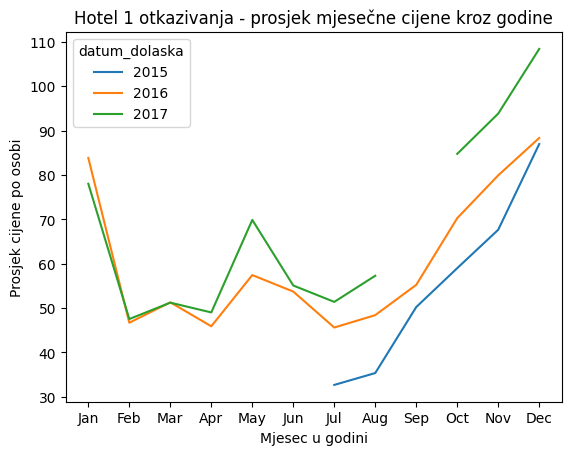

In [52]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_one.unstack(level=0).plot()
plt.title('Hotel 1 otkazivanja - prosjek mjesečne cijene kroz godine')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()


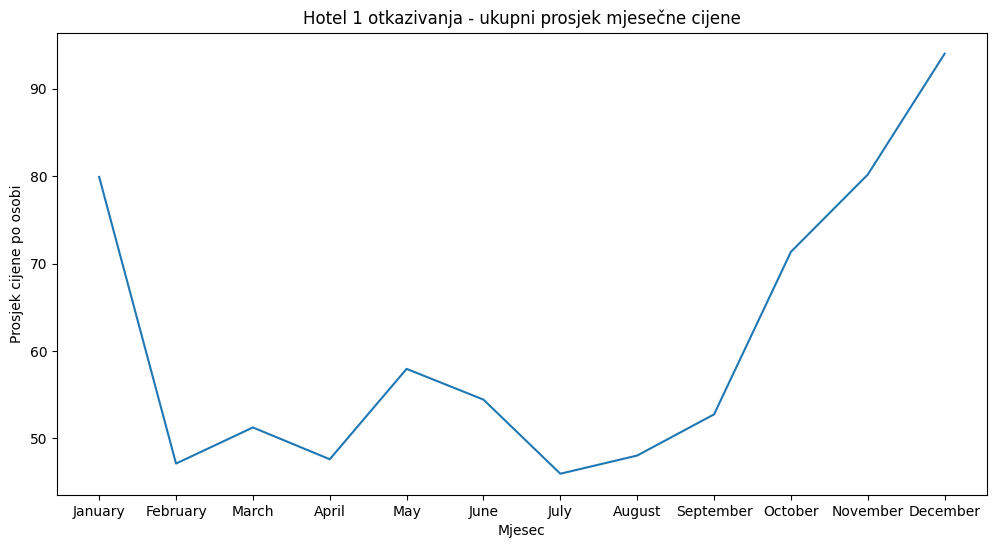

In [53]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_one.plot()
plt.title('Hotel 1 otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

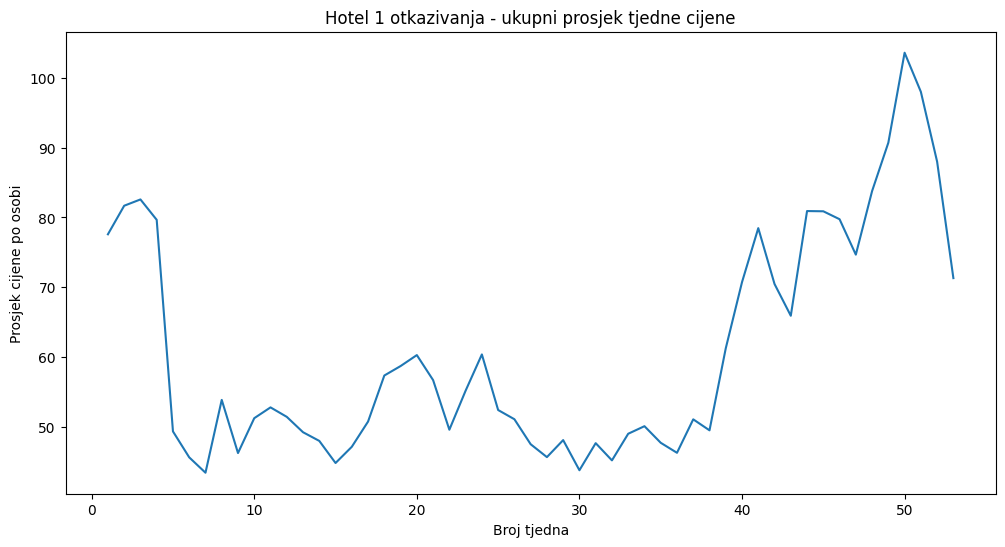

In [54]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_one.plot()
plt.title('Hotel 1 otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

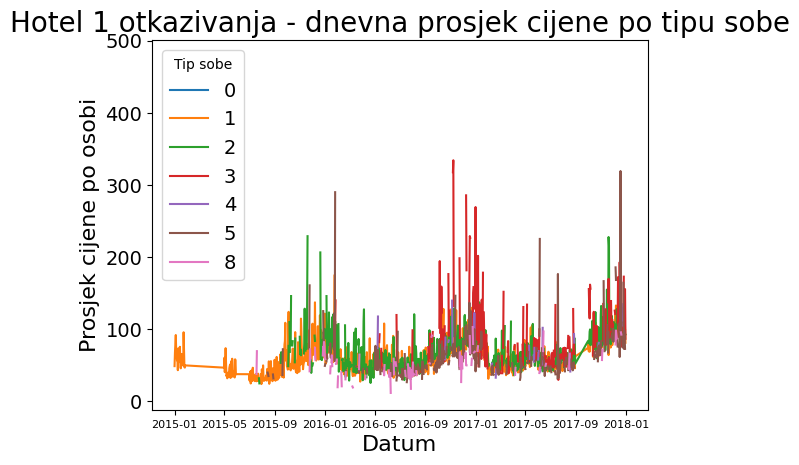

In [55]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - dnevna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

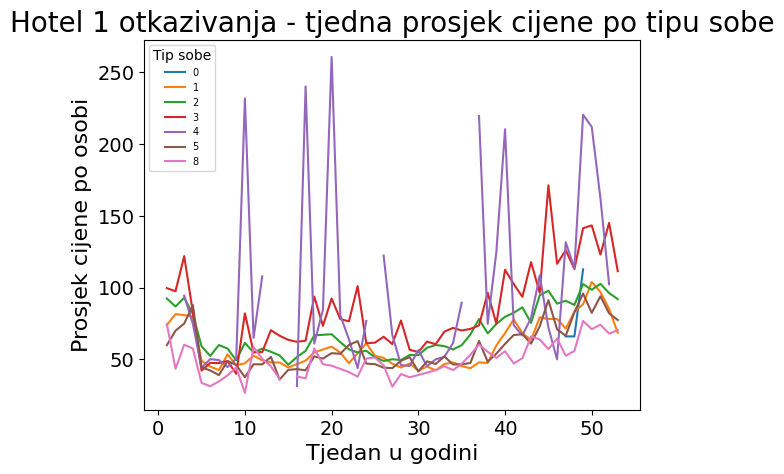

In [56]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - tjedna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

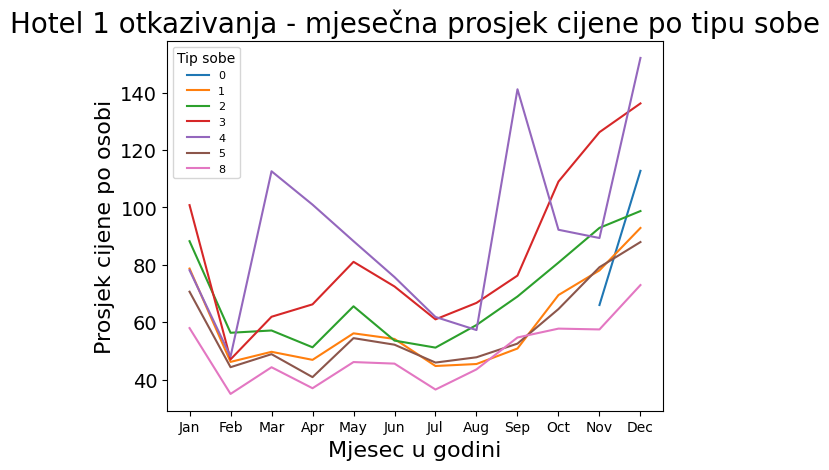

In [57]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - mjesečna prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=8)
plt.show()

<Figure size 2800x2000 with 0 Axes>

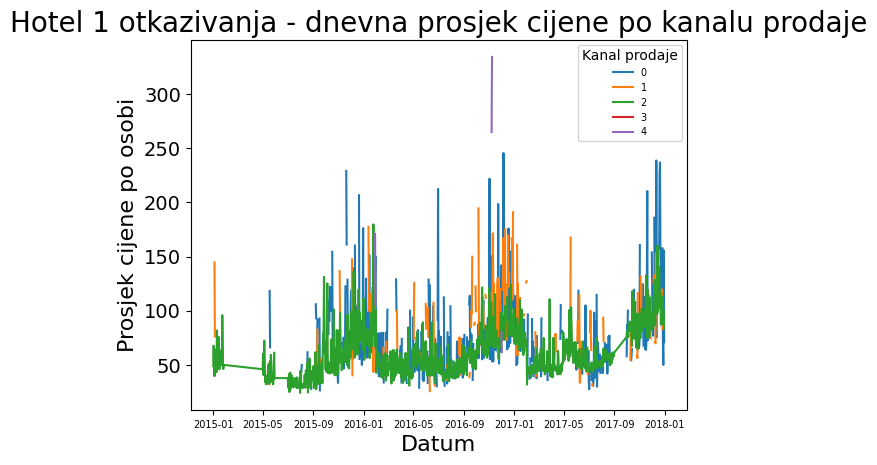

In [58]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - dnevna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

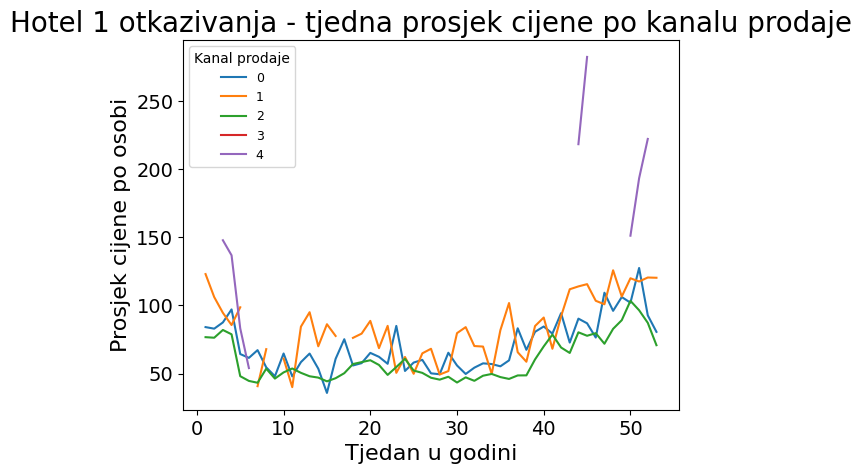

In [59]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - tjedna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Tjedan u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

<Figure size 2800x2000 with 0 Axes>

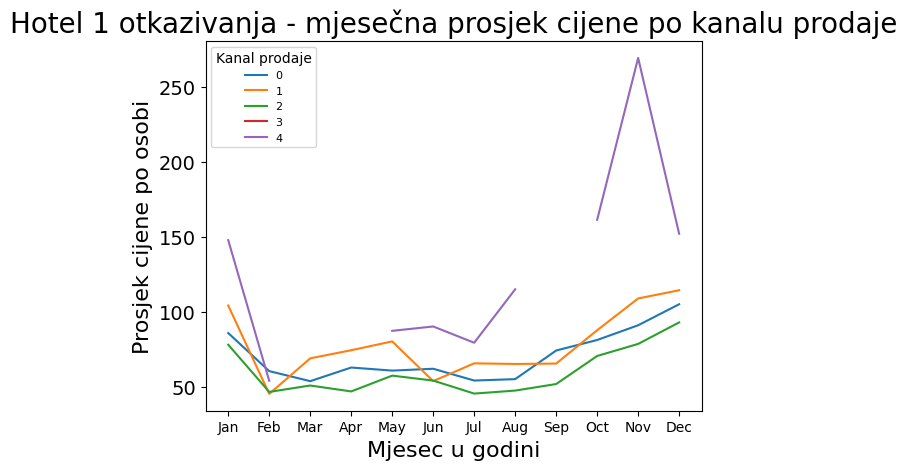

In [60]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_one.unstack(level=1).plot()
plt.title('Hotel 1 otkazivanja - mjesečna prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=8)
plt.show()

### HOTEL 1 ostvareni dolasci

<Figure size 2800x2000 with 0 Axes>

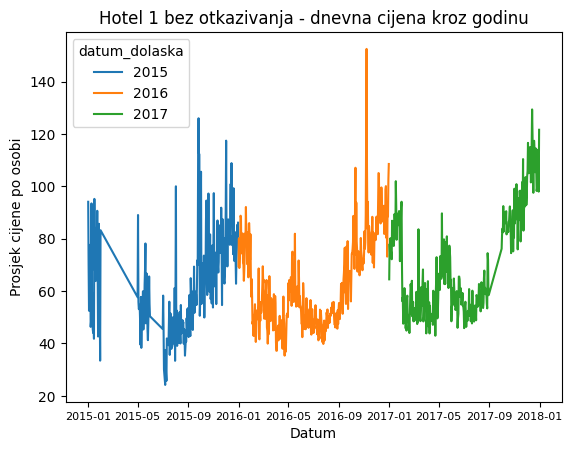

In [61]:
plt.figure(figsize=(28, 20))
average_daily_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - dnevna cijena kroz godinu')
plt.xlabel('Datum')
plt.xticks(fontsize=8)
plt.ylabel('Prosjek cijene po osobi')
plt.show()

<Figure size 2800x2000 with 0 Axes>

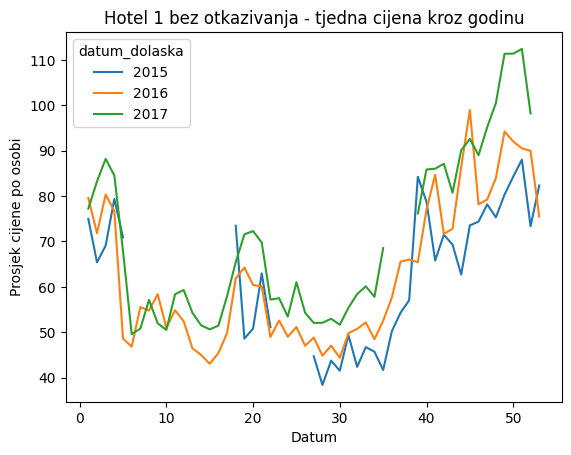

In [62]:
plt.figure(figsize=(28, 20))
average_weekly_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - tjedna cijena kroz godinu')
plt.xlabel('Datum')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


<Figure size 2800x2000 with 0 Axes>

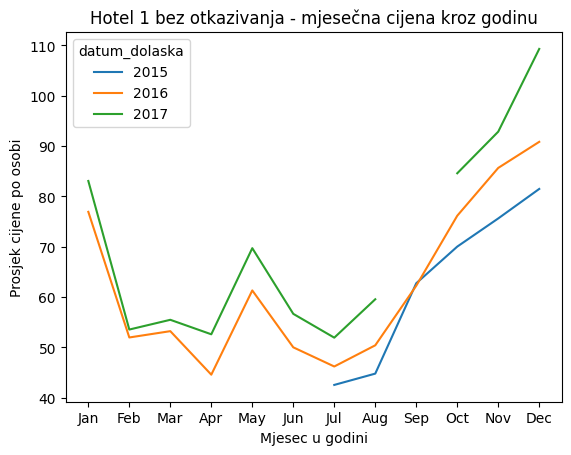

In [63]:
plt.figure(figsize=(28, 20))
average_monthly_price_hotel_one_no.unstack(level=0).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečna cijena kroz godinu')
plt.xlabel('Mjesec u godini')
plt.ylabel('Prosjek cijene po osobi')
plt.xticks(range(1, 13), [calendar.month_name[i][0:3] for i in range(1, 13)])
plt.show()

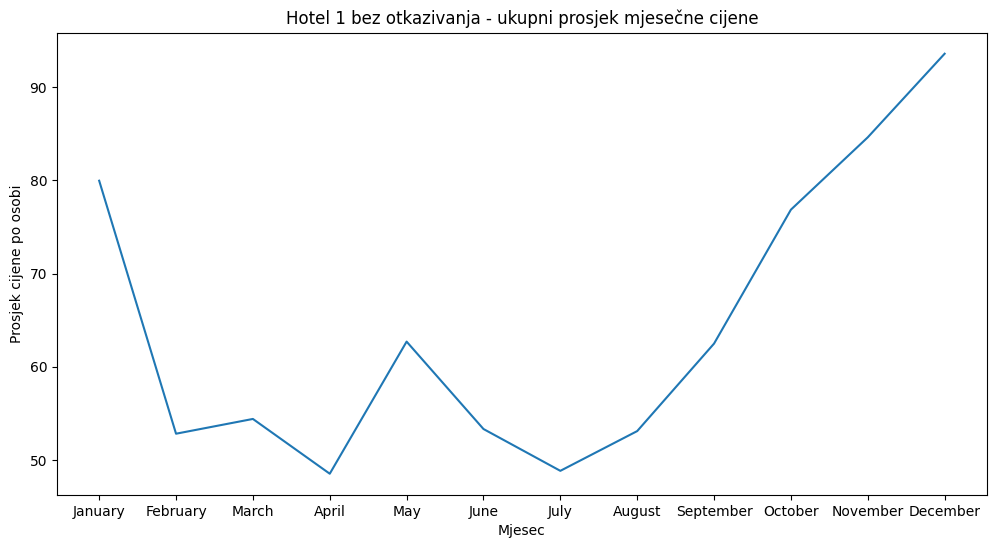

In [64]:
plt.figure(figsize=(12, 6))
overall_average_monthly_price_hotel_one_no.plot()
plt.title('Hotel 1 bez otkazivanja - ukupni prosjek mjesečne cijene')
plt.xticks(range(1, 13), [calendar.month_name[i] for i in range(1, 13)])
plt.xlabel('Mjesec')
plt.ylabel('Prosjek cijene po osobi')
plt.show()


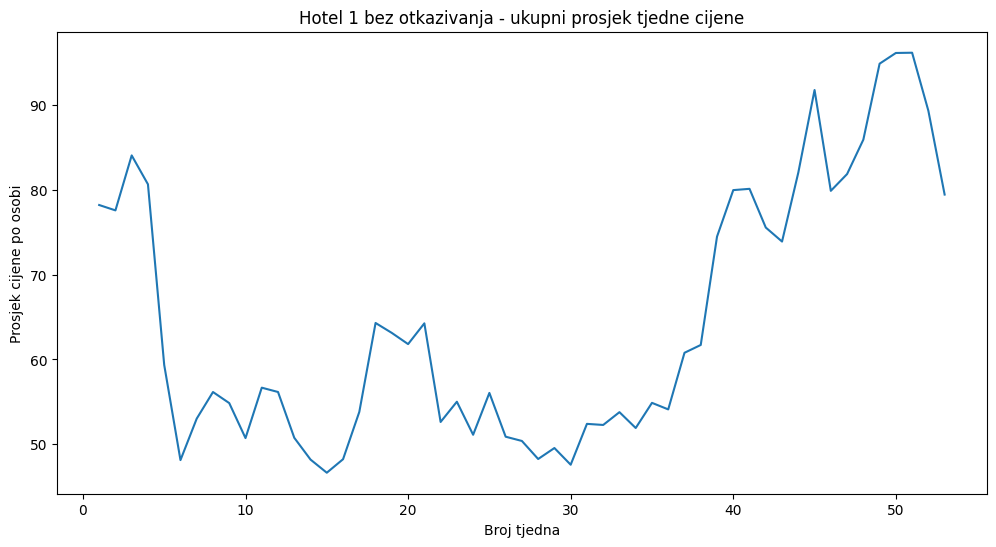

In [65]:
plt.figure(figsize=(12, 6))
overall_average_weekly_price_hotel_one_no.plot()
plt.title('Hotel 1 bez otkazivanja - ukupni prosjek tjedne cijene')
plt.xlabel('Broj tjedna')
plt.ylabel('Prosjek cijene po osobi')
plt.show()



<Figure size 2800x2000 with 0 Axes>

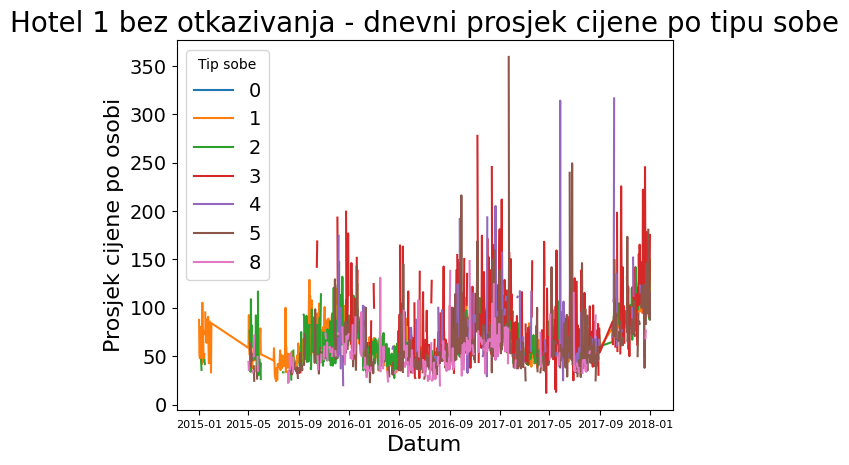

In [66]:
plt.figure(figsize=(28, 20))
average_by_daily_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - dnevni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=14)
plt.show()




<Figure size 2800x2000 with 0 Axes>

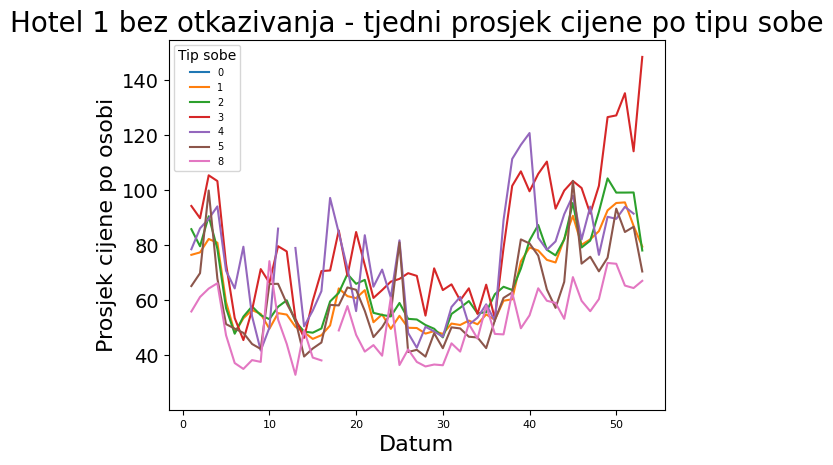

In [67]:
plt.figure(figsize=(28, 20))
average_by_weekly_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - tjedni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

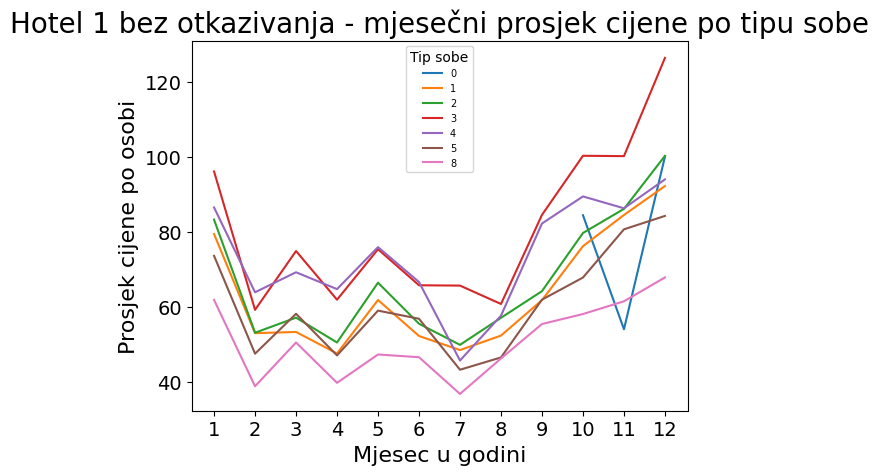

In [68]:
plt.figure(figsize=(28, 20))
average_by_monthly_room_type_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečni prosjek cijene po tipu sobe', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Tip sobe', fontsize=7)
plt.show()





<Figure size 2800x2000 with 0 Axes>

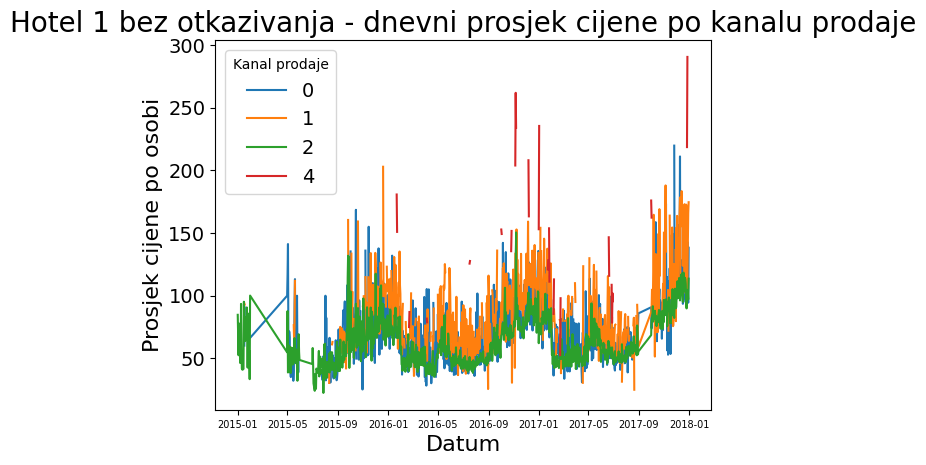

In [69]:
plt.figure(figsize=(28, 20))
average_by_daily_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - dnevni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=14)
plt.show()

<Figure size 2800x2000 with 0 Axes>

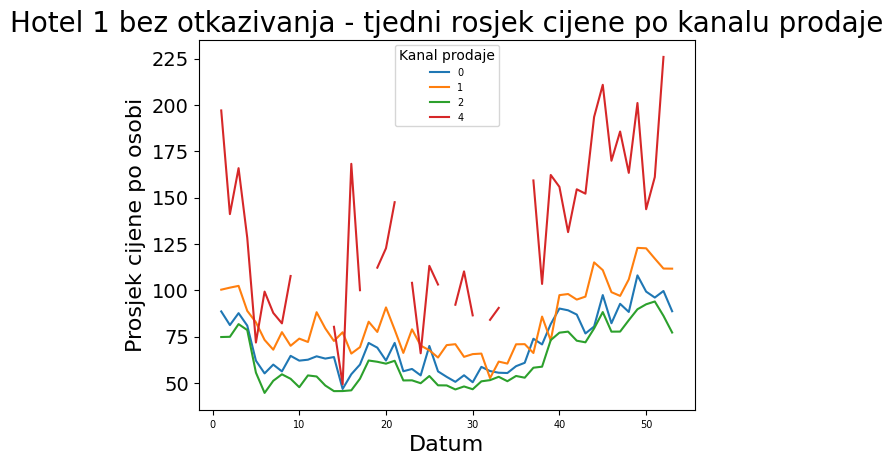

In [70]:
plt.figure(figsize=(28, 20))
average_by_weekly_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - tjedni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Datum', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=7)
plt.show()

<Figure size 2800x2000 with 0 Axes>

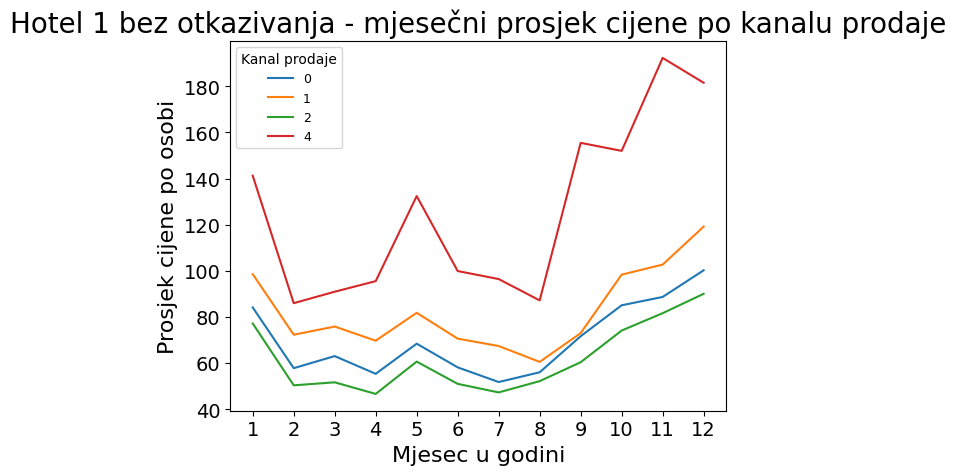

In [71]:
plt.figure(figsize=(28, 20))
average_by_monthly_sales_channel_hotel_one_no.unstack(level=1).plot()
plt.title('Hotel 1 bez otkazivanja - mjesečni prosjek cijene po kanalu prodaje', fontsize=20)
plt.xlabel('Mjesec u godini', fontsize=16)
plt.ylabel('Prosjek cijene po osobi', fontsize=16)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Kanal prodaje', fontsize=9)
plt.show()

# Ostale analize i vizuali

### Datumi gdje je datum otkazivanja nakon datuma dolaska

In [72]:
krivi_datumi = data_cancellations[data_cancellations['datum_otkazivanja_rezervacije'] > data_cancellations['datum_dolaska']]
print(f"Ukupno {len(krivi_datumi)} redaka s neispravnim datumima")
print(krivi_datumi.head(3))

Ukupno 1950 redaka s neispravnim datumima
       hotel_id datum_dolaska datum_otkazivanja_rezervacije zemlja_gosta  \
11067         1    2015-01-01                    2015-07-01          PRT   
11072         1    2015-05-02                    2015-06-25          PRT   
11073         1    2015-05-02                    2015-07-02          PRT   

       kanal_prodaje_id  tip_sobe_id  cijena_nocenja  gost_id  ukupno_gostiju  \
11067                 2            1       97.930547  1048285               2   
11072                 2            1       72.739914  1019190               1   
11073                 2            1       81.380511  1001102               2   

       duljina_boravka  raspon_dolazak_rezervacija  
11067                4                           0  
11072                4                         105  
11073                5                          35  


### Vizualizacija ukupnog broja gostiju po danu, tjednu i mjesecu po hotelu

In [73]:
DATA_HOTEL0_BASE_PATH = '../data/interim/hotel_0'
DATA_HOTEL1_BASE_PATH = '../data/interim/hotel_1'

#### Hotel 0

##### Dnevna razina

In [74]:
NumberOfGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "daily", "daily_new_guests.parquet"))


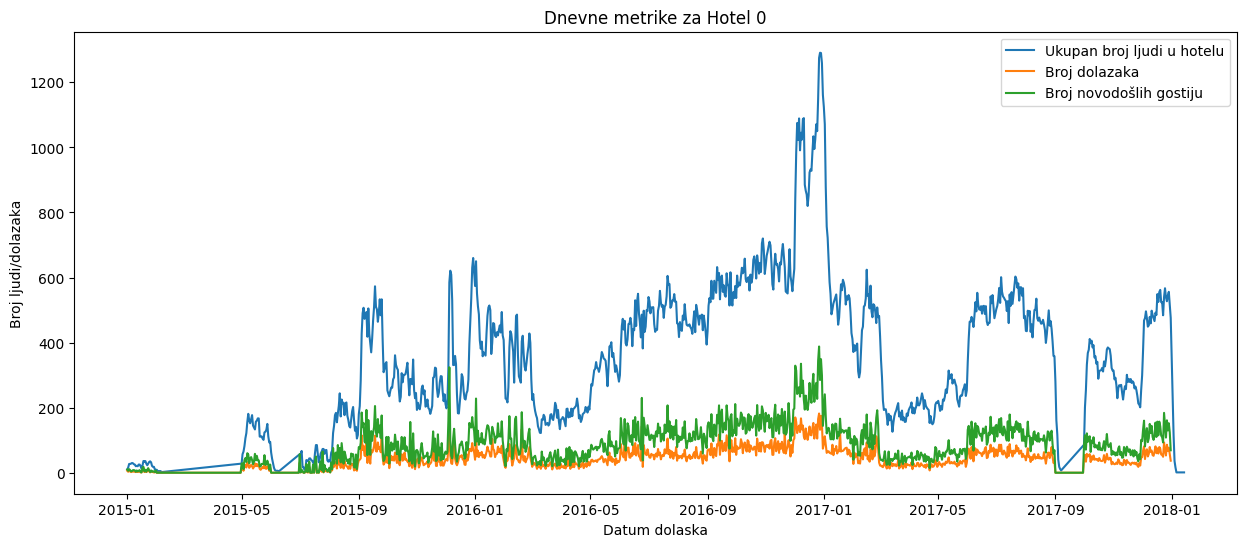

In [75]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsDailyCity.index, NumberOfGuestsDailyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu')

plt.plot(NumberOfArrivalsDailyCity.index, NumberOfArrivalsDailyCity['broj_dolazaka'], label='Broj dolazaka')

plt.plot(NumberOfNewGuestsDailyCity.index, NumberOfNewGuestsDailyCity['ukupno_gostiju'], label='Broj novodošlih gostiju')

plt.title('Dnevne metrike za Hotel 0')
plt.xlabel('Datum dolaska')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()

plt.show()

##### Tjedna razina

In [76]:
NumberOfGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "weekly", "weekly_new_guests.parquet"))


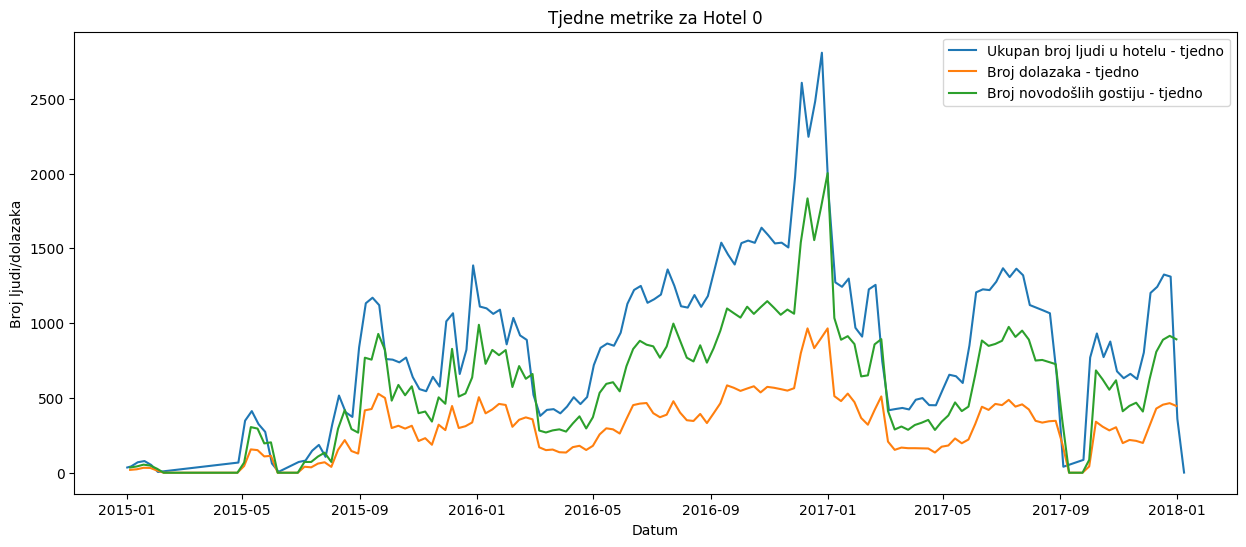

In [77]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsWeeklyCity.index, NumberOfGuestsWeeklyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - tjedno')
plt.plot(NumberOfArrivalsWeeklyCity.index, NumberOfArrivalsWeeklyCity['broj_dolazaka'], label='Broj dolazaka - tjedno')
plt.plot(NumberOfNewGuestsWeeklyCity.index, NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - tjedno')

plt.title('Tjedne metrike za Hotel 0')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()

##### Mjesečna razina

In [78]:
NumberOfGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


In [79]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsMonthlyCity.index, NumberOfGuestsMonthlyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - mjesečno')
plt.plot(NumberOfArrivalsMonthlyCity.index, NumberOfArrivalsMonthlyCity['broj_dolazaka'], label='Broj dolazaka - mjesečno')
plt.plot(NumberOfNewGuestsMonthlyCity.index, NumberOfNewGuestsMonthlyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - mjesečno')

plt.title('Mjesečne metrike za Hotel 0')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


KeyError: 'ukupno_gostiju'

<Figure size 1500x600 with 0 Axes>

##### Godišnja razina

In [ ]:
NumberOfGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyCity = pd.read_parquet(os.path.join(DATA_HOTEL0_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsYearlyCity.index, NumberOfGuestsYearlyCity['ukupno_gostiju'], label='Ukupan broj ljudi u hotelu - godišnje')
plt.plot(NumberOfArrivalsYearlyCity.index, NumberOfArrivalsYearlyCity['broj_dolazaka'], label='Broj dolazaka - godišnje')
plt.plot(NumberOfNewGuestsYearlyCity.index, NumberOfNewGuestsYearlyCity['ukupno_gostiju'], label='Broj novodošlih gostiju - godišnje')

plt.title('Godišnje metrike za Hotel 0')
plt.xlabel('Datum')
plt.xlim(left=NumberOfGuestsYearlyCity.index.min(),right=NumberOfGuestsYearlyCity.index.max())
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


#### Hotel 1

##### Dnevna razina

In [ ]:
NumberOfGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_guests.parquet"))
NumberOfArrivalsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_arrivals.parquet"))
NumberOfNewGuestsDailyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "daily", "daily_new_guests.parquet"))

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsDailyResort.index, NumberOfGuestsDailyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Dnevno')
plt.plot(NumberOfArrivalsDailyResort.index, NumberOfArrivalsDailyResort['broj_dolazaka'], label='Broj dolazaka - Dnevno')
plt.plot(NumberOfNewGuestsDailyResort.index, NumberOfNewGuestsDailyResort['ukupno_gostiju'], label='Broj novih gostiju - Dnevno')

plt.title('Dnevne metrike za Hotel 1 (Resort)')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


##### Tjedna razina

In [ ]:
NumberOfGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_guests.parquet"))
NumberOfArrivalsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_arrivals.parquet"))
NumberOfNewGuestsWeeklyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "weekly", "weekly_new_guests.parquet"))


In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsWeeklyResort.index, NumberOfGuestsWeeklyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Tjedno')
plt.plot(NumberOfArrivalsWeeklyResort.index, NumberOfArrivalsWeeklyResort['broj_dolazaka'], label='Broj dolazaka - Tjedno')
plt.plot(NumberOfNewGuestsWeeklyResort.index, NumberOfNewGuestsWeeklyResort['ukupno_gostiju'], label='Broj novih gostiju - Tjedno')

plt.title('Tjedne metrike za Hotel 1 (Resort)')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


##### Mjesečna razina

In [ ]:
NumberOfGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_guests.parquet"))
NumberOfArrivalsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_arrivals.parquet"))
NumberOfNewGuestsMonthlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "monthly", "monthly_new_guests.parquet"))


In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsMonthlyResort.index, NumberOfGuestsMonthlyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Mjesečno')
plt.plot(NumberOfArrivalsMonthlyResort.index, NumberOfArrivalsMonthlyResort['broj_dolazaka'], label='Broj dolazaka - Mjesečno')
plt.plot(NumberOfNewGuestsMonthlyResort.index, NumberOfNewGuestsMonthlyResort['ukupno_gostiju'], label='Broj novih gostiju - Mjesečno')

plt.title('Mjesečne metrike za Hotel 1 (Resort)')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.legend()
plt.show()


##### Godišnja razina

In [ ]:
NumberOfGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_guests.parquet"))
NumberOfArrivalsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_arrivals.parquet"))
NumberOfNewGuestsYearlyResort = pd.read_parquet(os.path.join(DATA_HOTEL1_BASE_PATH, "yearly", "yearly_new_guests.parquet"))

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(NumberOfGuestsYearlyResort.index, NumberOfGuestsYearlyResort['ukupno_gostiju'], label='Ukupan broj gostiju - Godišnje')
plt.plot(NumberOfArrivalsYearlyResort.index, NumberOfArrivalsYearlyResort['broj_dolazaka'], label='Broj dolazaka - Godišnje')
plt.plot(NumberOfNewGuestsYearlyResort.index, NumberOfNewGuestsYearlyResort['ukupno_gostiju'], label='Broj novih gostiju - Godišnje')

plt.title('Godišnje metrike za Hotel 1 (Resort)')
plt.xlabel('Datum')
plt.ylabel('Broj ljudi/dolazaka')
plt.xlim(left=NumberOfGuestsYearlyResort.index.min(), right=NumberOfGuestsYearlyResort.index.max())
plt.legend()
plt.show()


### Zanimljiva anomalija u broju novodošlih gostiju u Hotel 0

In [ ]:
indexes = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days > 1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

for start, end in periods:
    print(f"Periodi gdje je broj novodošlih gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

In [ ]:
indexes_valid = NumberOfNewGuestsDailyCity[NumberOfNewGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

In [ ]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfNewGuestsDailyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')
plt.plot(NumberOfNewGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednsosti')

plt.title('Broj novih gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

ZAKLJUČAK - UKOLIKO SE MODELIRA BROJ NOVIH GOSTIJU/DOLAZAKA
- dio podataka gdje je duljina perioda gdje hotel nema gostiju dulja od tjedan dana ima smisla izbaciti, zajedno s podacima koji prethode, ako govorimo o "malom "uzorku "čistih" podataka koji prethode dugim anomalijama
- kako je taj "mali" uzorak podataka koji smijemo izbaciti arbitraran, moguće je modelirati na više načina, s većom/manjom količinom izbacivanja podataka
- manje periode ima smisla modelirati na način da se agregiraju srednje vrijednosti podatka iz susjedstva (npr. tjedan dana prije i poslije) ili interpolirati srednje vrijednosti iz susjedstva
- prethodno može biti primjenjemo na dulje periode, ukoliko je potrebno
- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) ako su ciljani podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukupnih gosti na bilo kojoj vremenskoj bazi jednak nuli


In [ ]:
indexes = NumberOfNewGuestsWeeklyCity[NumberOfNewGuestsWeeklyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]

for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i - 1]).days > 7:  
        end_date = indexes[i - 1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

plt.figure(figsize=(16, 8))
plt.plot(NumberOfNewGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')

anomalous_period_count = 1
normal_period_count = 1

if periods[0][0] != NumberOfNewGuestsWeeklyCity.index.min():
    first_normal_end = periods[0][0] - pd.Timedelta(weeks=1)
    plt.text(NumberOfGuestsWeeklyCity.index.min(), max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

for i, (start, end) in enumerate(periods):
    plt.axvline(x=start, color='red', linestyle='--', lw=2)
    plt.axvline(x=end, color='red', linestyle='--', lw=2)
    plt.text(start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period anomalija {anomalous_period_count}', color='red', rotation=90)
    anomalous_period_count += 1

    if i < len(periods) - 1:
        next_start = periods[i + 1][0]
        midpoint = pd.to_datetime((end.value + next_start.value) // 2)
        plt.text(midpoint, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
        normal_period_count += 1

if periods[-1][1] != NumberOfNewGuestsWeeklyCity.index.max():
    last_normal_start = periods[-1][1] + pd.Timedelta(weeks=1)
    plt.text(last_normal_start, max(NumberOfNewGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

plt.title('Broj novih gostiju City Hotel an tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')

plt.legend()
plt.show()


KOMENTAR
- period 1, 2 te 3 označavaju periode podatak iz dataseta gdje postoji dnevni broj gostiju različit od nule, dok periodi anomalija vremenske
periode gdje je ukupan broj gostiju jedan nuli
- prvi period anomalija ćemo izbaciti iz dataseta, kao i period 1 regularnih podataka, kako se radi o kratkom peroidu validnih podataka 
 (imamo 30 dana zapisa i 88 dana bez gostiju)
- drugi period anomalija, kao i treći, razrješiti će se na sljedeći način:
   - za drugi period anomalija gledati ćemo period 2 te određeni dio perioda 3 "zdravih podataka" te izračunati daily mean te dodati tu vrijednosti danima anomalija
   - za treći period koristiti ćemo dio trećeg te četvrtog perioda zdravih podataka i na taj način amputirati podatke u dane anomalija
- ovo se treba raditi na  podatkovnom okviru s dnevnim zapisima, kako na tjednoj razini ne vidimo veću granulaciju, odnosno postoje dani (jedan ili dva u nizu) u kojima 
  nema gostiju, ali koji se "ne vide" na tjednoj bazi,ali utječu na brog gostiju